VERI SETINI KAGGLEDAN ÇEKİYORUZ

In [1]:
!pip install kaggle

In [2]:
from google.colab import files
files.upload() # "kaggle.json" dosyasını yükleyin


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"aleynakocabey","key":"6312752fc9086d07e473a489fa5ff72d"}'}

In [3]:
# kaggle.json dosyasını uygun dizine taşıyın
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d rashikrahmanpritom/plant-disease-recognition-dataset
!unzip plant-disease-recognition-dataset.zip -d /content/data


Dataset URL: https://www.kaggle.com/datasets/rashikrahmanpritom/plant-disease-recognition-dataset
License(s): CC0-1.0
100% 1.25G/1.25G [01:01<00:00, 18.6MB/s]
100% 1.25G/1.25G [01:01<00:00, 21.7MB/s]
Archive:  plant-disease-recognition-dataset.zip
  inflating: /content/data/Test/Test/Healthy/8ddaa5a5caa5caa8.jpg  
  inflating: /content/data/Test/Test/Healthy/8ddaac1bd6c8cd0a.jpg  
  inflating: /content/data/Test/Test/Healthy/8ddd5ec1c0de38c4.jpg  
  inflating: /content/data/Test/Test/Healthy/8def3f60308ab41b.jpg  
  inflating: /content/data/Test/Test/Healthy/8def4d91382175c3.jpg  
  inflating: /content/data/Test/Test/Healthy/8df452e2e38c0b6e.jpg  
  inflating: /content/data/Test/Test/Healthy/8dfae9d78cc32089.jpg  
  inflating: /content/data/Test/Test/Healthy/8e3dbccdfe08c850.jpg  
  inflating: /content/data/Test/Test/Healthy/8e68163c62dc57d5.jpg  
  inflating: /content/data/Test/Test/Healthy/8e6a823cce9ff40c.jpg  
  inflating: /content/data/Test/Test/Healthy/8e77857194a59a87.jpg  
  in

In [5]:
import os

def total_files(folder_path):
    num_files = len([f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))])
    return num_files

train_files_healthy = "/content/data/Train/Train/Healthy"
train_files_powdery = "/content/data/Train/Train/Powdery"
train_files_rust = "/content/data/Train/Train/Rust"

test_files_healthy = "/content/data/Test/Test/Healthy"
test_files_powdery = "/content/data/Test/Test/Powdery"
test_files_rust = "/content/data/Test/Test/Rust"

valid_files_healthy = "/content/data/Validation/Validation/Healthy"
valid_files_powdery = "/content/data/Validation/Validation/Powdery"
valid_files_rust = "/content/data/Validation/Validation/Rust"

In [6]:
print("Number of healthy leaf images in training set", total_files(train_files_healthy))
print("Number of powder leaf images in training set", total_files(train_files_powdery))
print("Number of rusty leaf images in training set", total_files(train_files_rust))

print("========================================================")

print("Number of healthy leaf images in test set", total_files(test_files_healthy))
print("Number of powder leaf images in test set", total_files(test_files_powdery))
print("Number of rusty leaf images in test set", total_files(test_files_rust))

print("========================================================")

print("Number of healthy leaf images in validation set", total_files(valid_files_healthy))
print("Number of powder leaf images in validation set", total_files(valid_files_powdery))
print("Number of rusty leaf images in validation set", total_files(valid_files_rust))

Number of healthy leaf images in training set 458
Number of powder leaf images in training set 430
Number of rusty leaf images in training set 434
Number of healthy leaf images in test set 50
Number of powder leaf images in test set 50
Number of rusty leaf images in test set 50
Number of healthy leaf images in validation set 20
Number of powder leaf images in validation set 20
Number of rusty leaf images in validation set 20


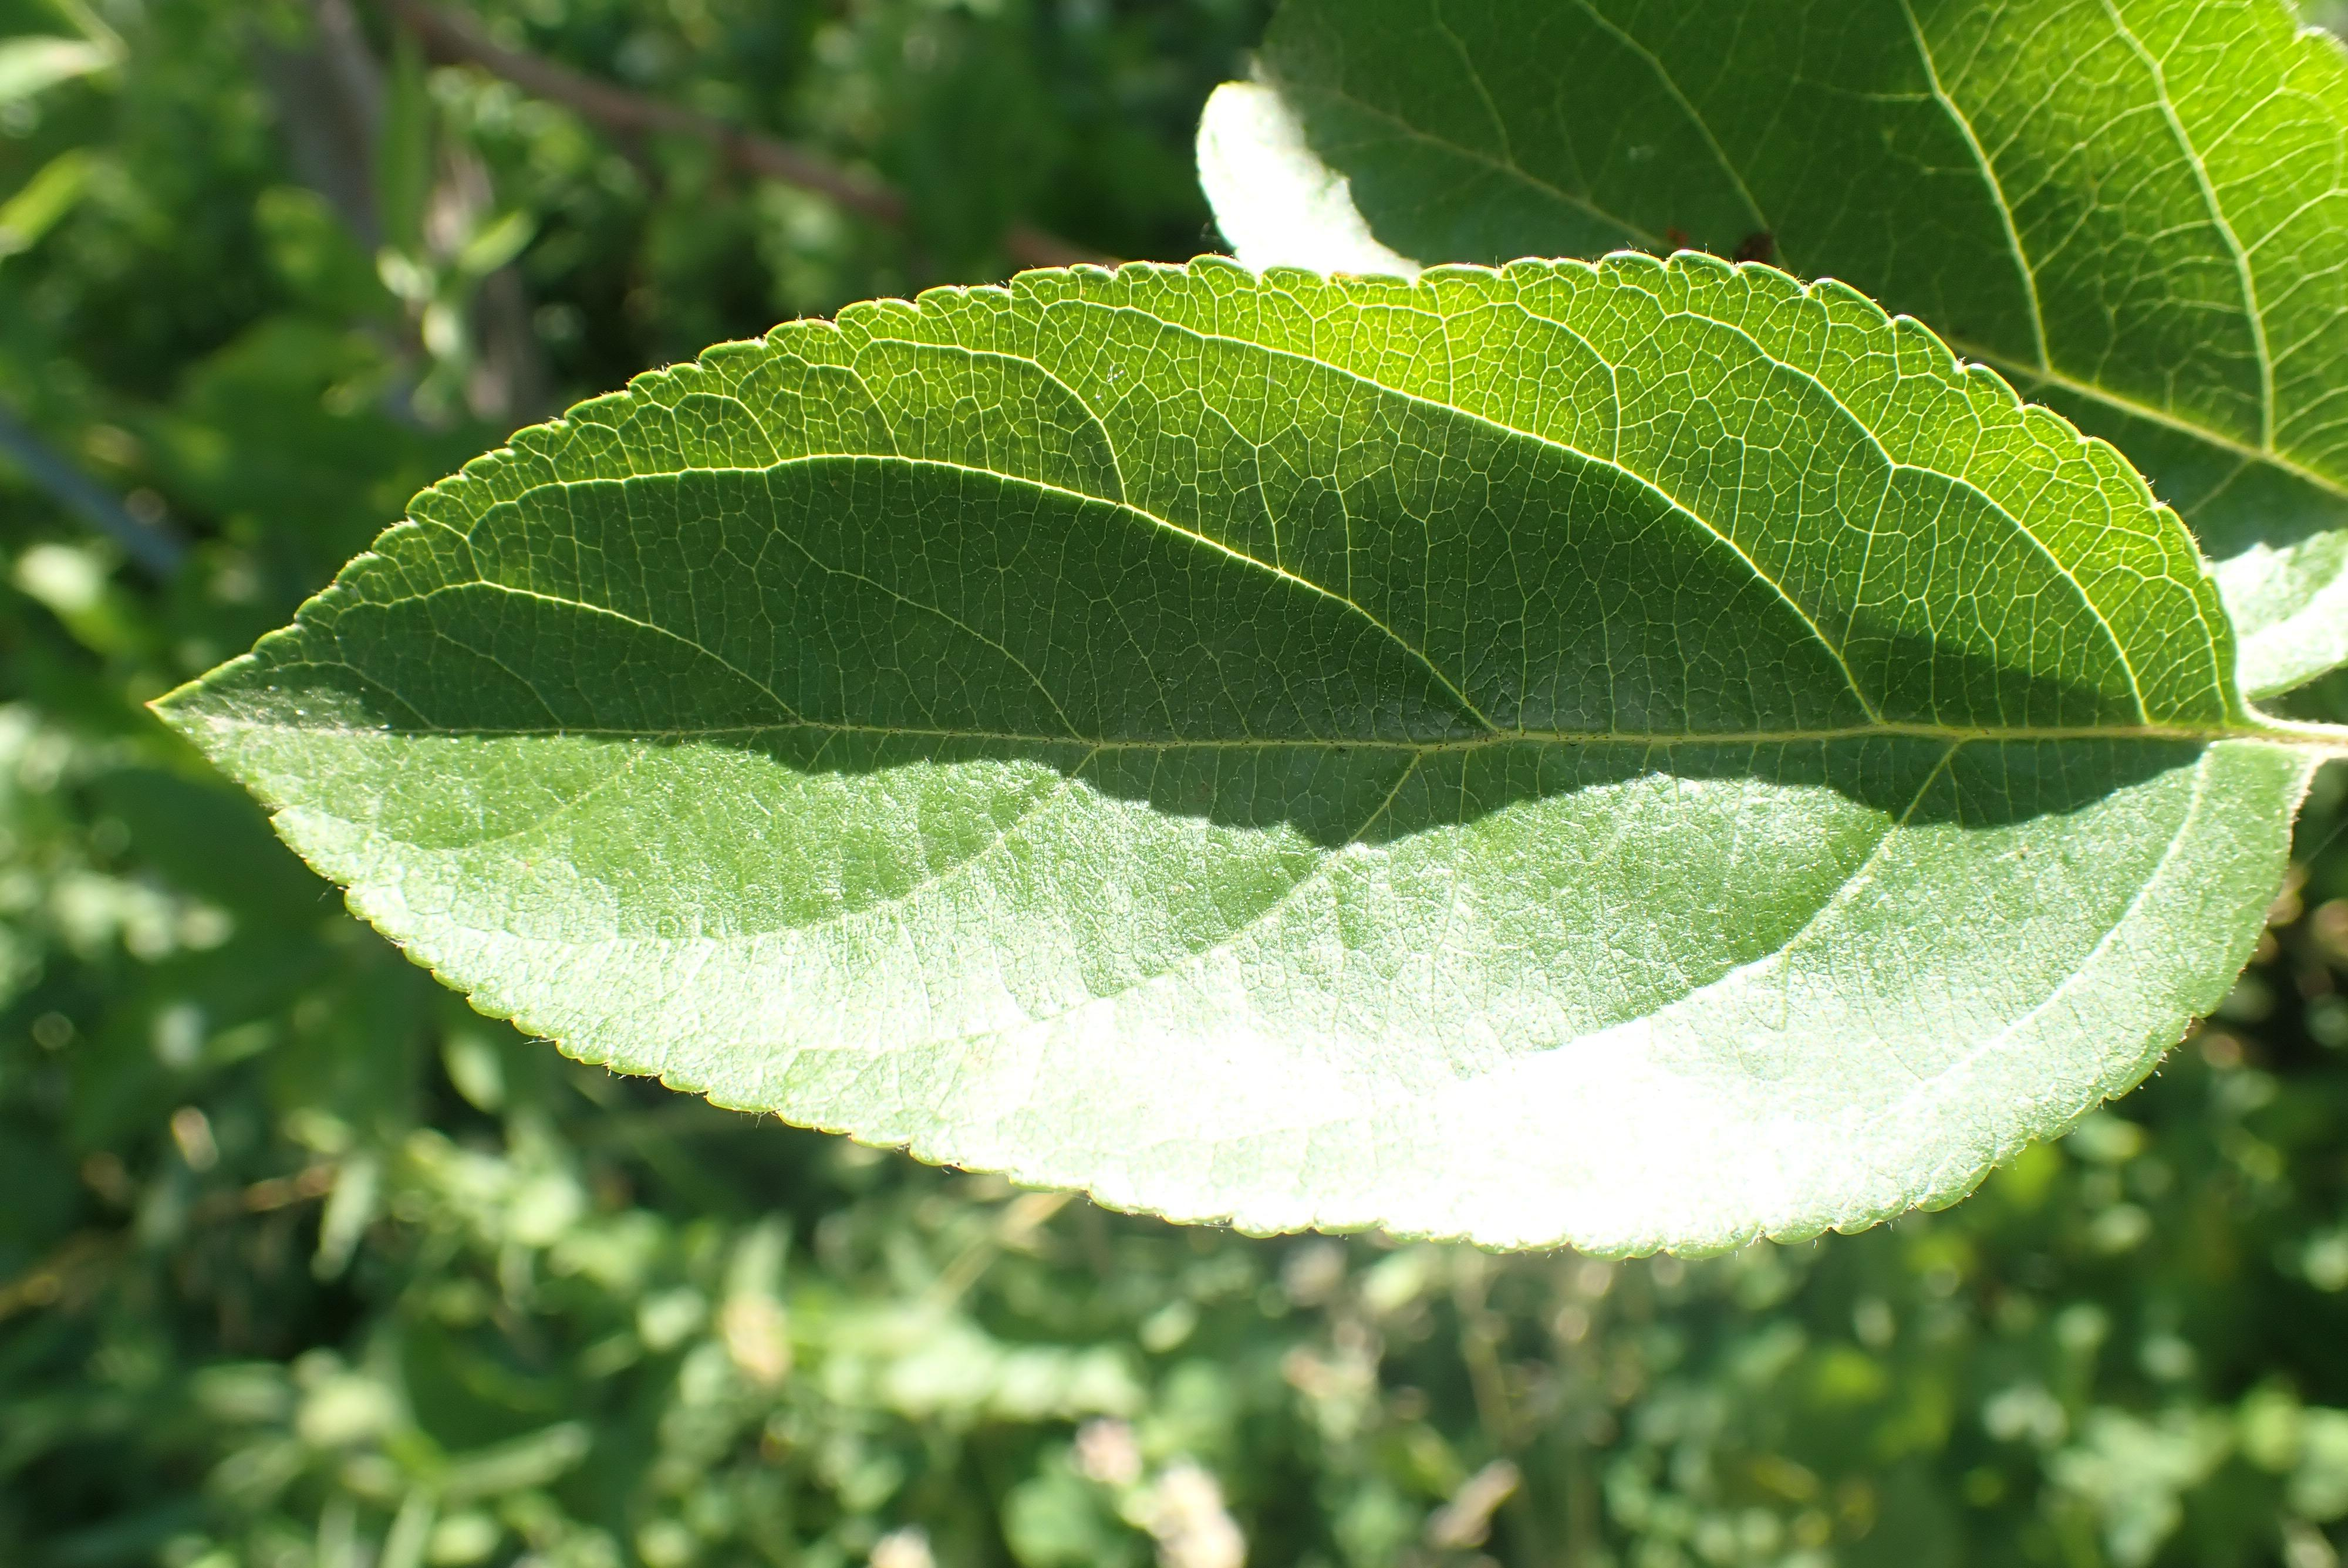

In [7]:
from PIL import Image
import IPython.display as display

image_path = '/content/data/Train/Train/Healthy/802b59956a7aa5e7.jpg'

with open(image_path, 'rb') as f:
    display.display(display.Image(data=f.read(), width=500))

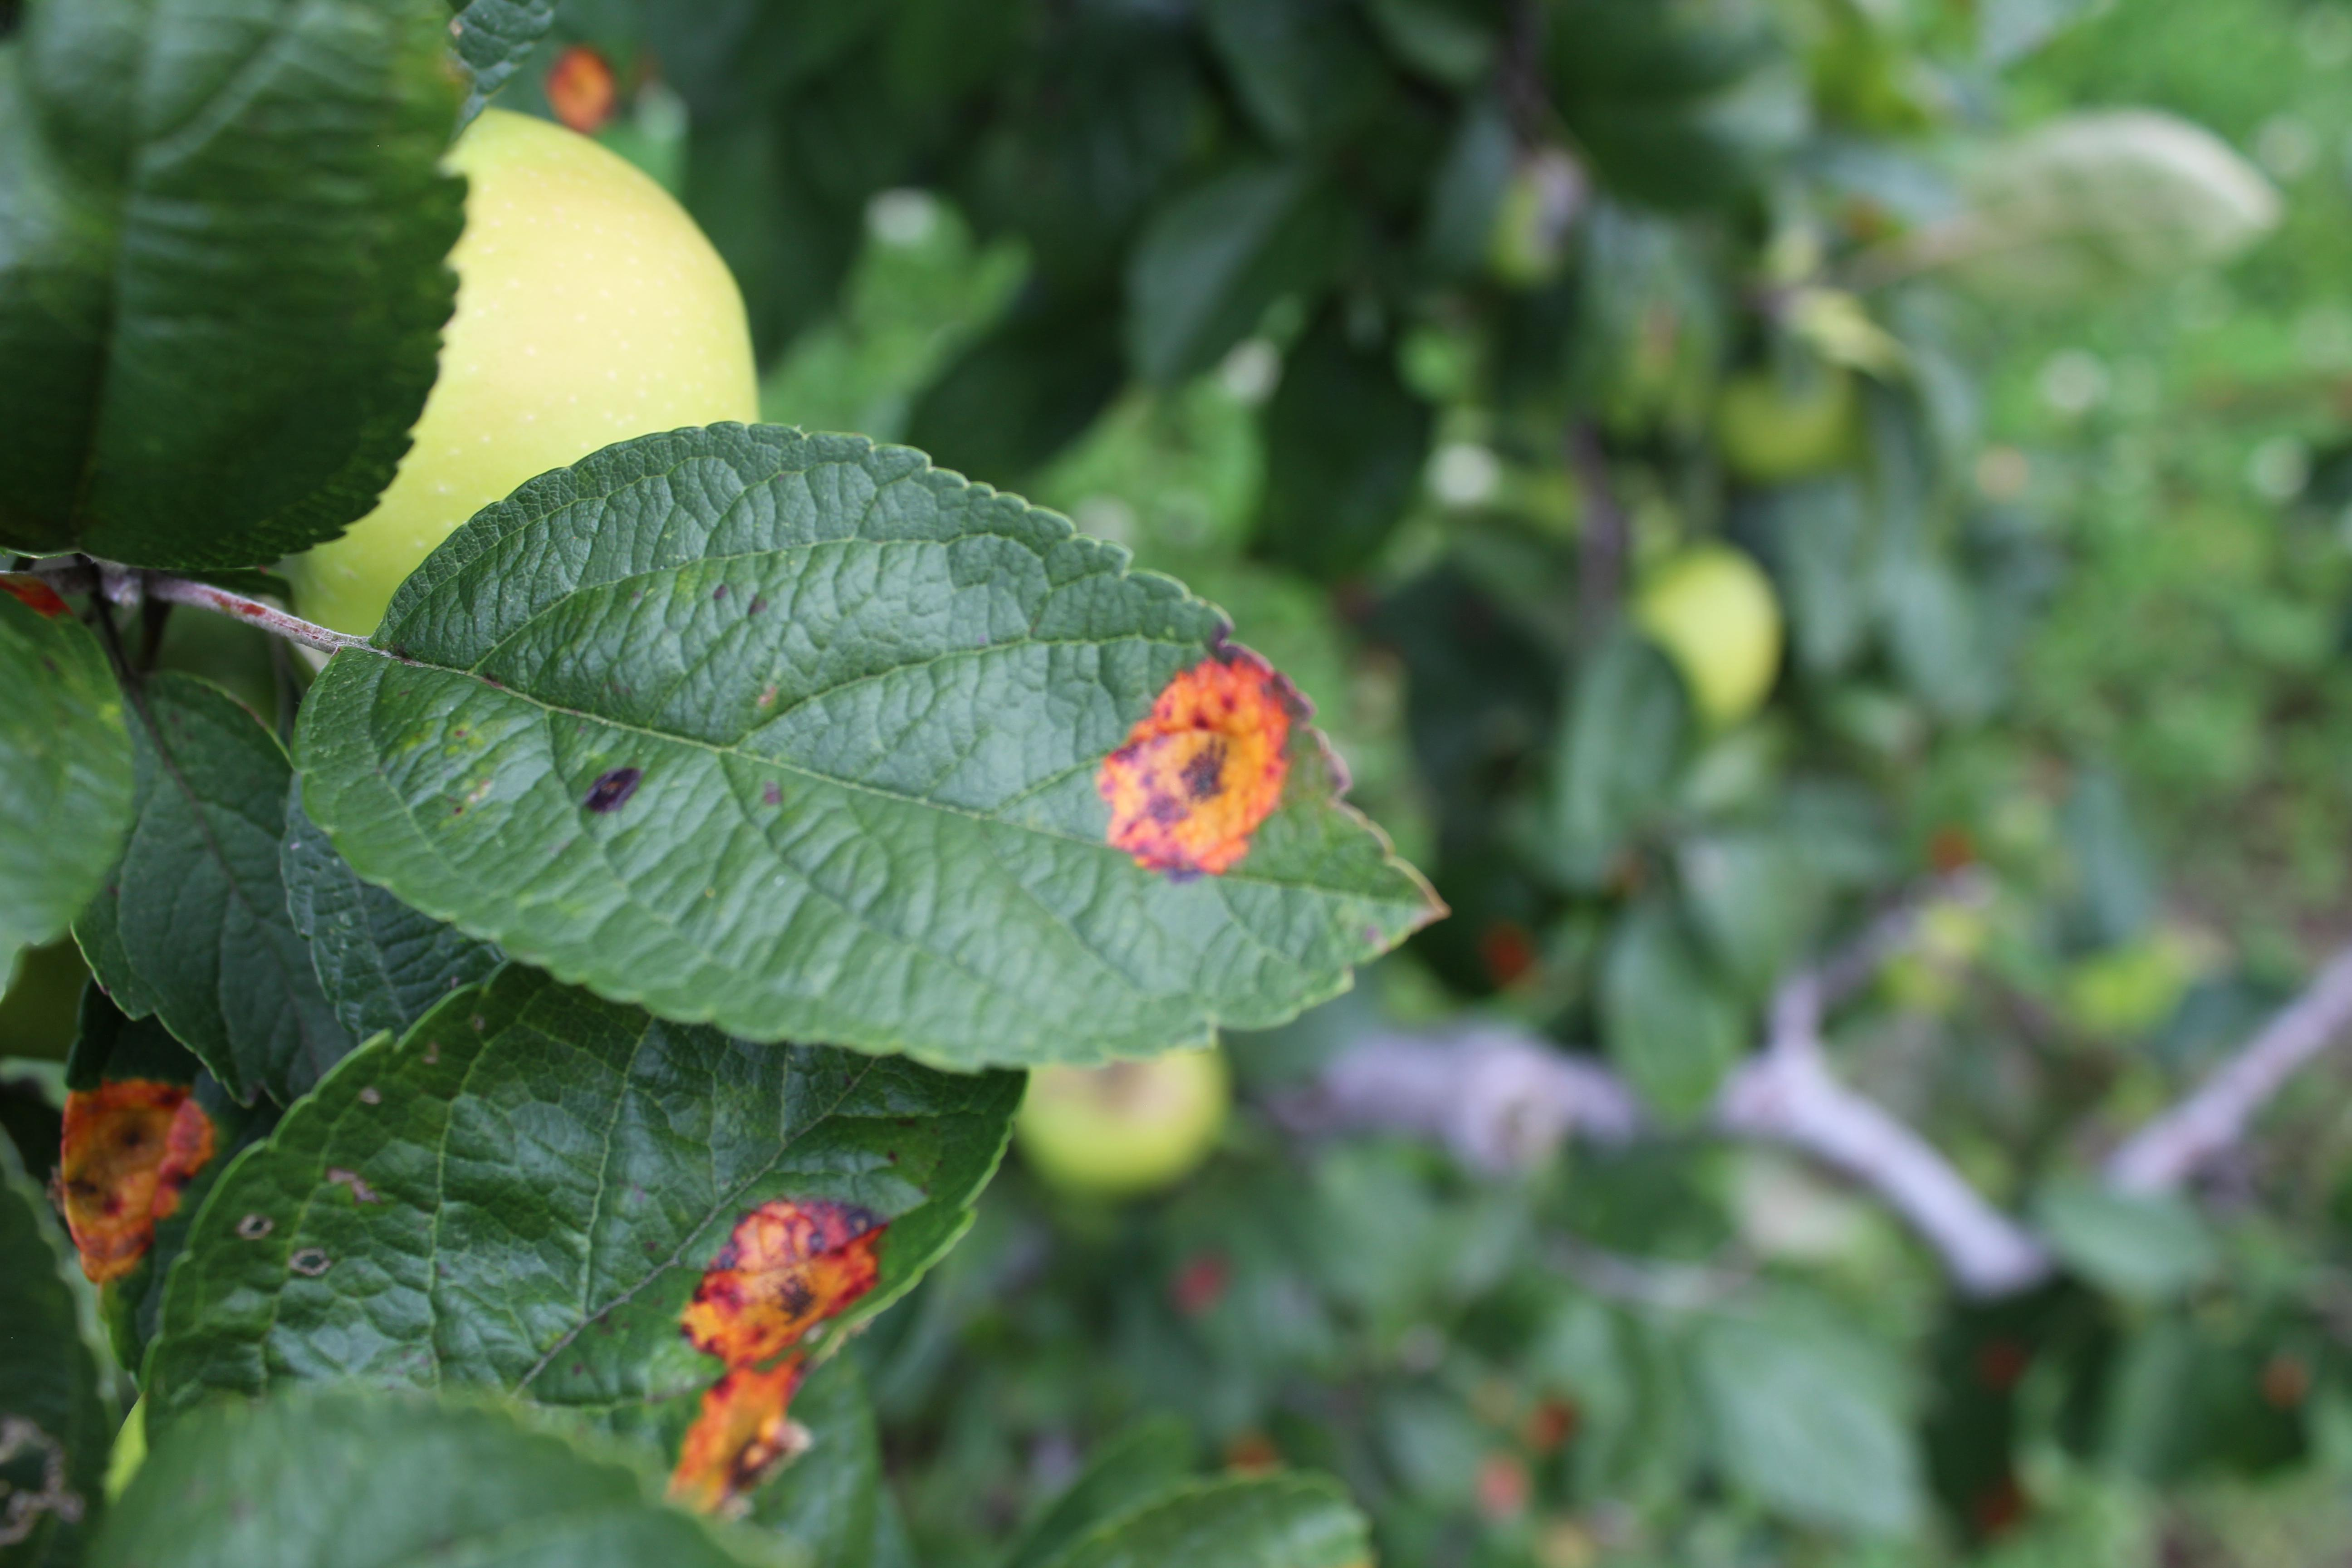

In [8]:
image_path = '/content/data/Train/Train/Rust/8161733dfc3c1c65.jpg'

with open(image_path, 'rb') as f:
    display.display(display.Image(data=f.read(), width=500))

VERİ ARTTIRMA VE NORMALIZASYON

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Veri artırma ve normalizasyon
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

valid_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    '/content/data/Train/Train',
    target_size=(225, 225),
    batch_size=32,
    class_mode='categorical'
)

valid_generator = valid_datagen.flow_from_directory(
    '/content/data/Validation/Validation',
    target_size=(225, 225),
    batch_size=32,
    class_mode='categorical'
)


Found 1322 images belonging to 3 classes.
Found 60 images belonging to 3 classes.


In [10]:
!pip install tensorflow-addons
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.metrics import Precision, Recall


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 13.0 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


MODELLEME AŞAMASI

In [17]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

model = Sequential([
    Conv2D(8, (3, 3), activation='relu', input_shape=(225, 225, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(16, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

# Modeli derleyelim
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=[
        'accuracy',
        Precision(name='precision'),
        Recall(name='recall'),
        tfa.metrics.F1Score(num_classes=3, threshold=0.5, average='micro', name='f1_score')
    ]
)


In [19]:
from keras.optimizers import Adam
from keras.metrics import Precision, Recall
import tensorflow_addons as tfa

model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(),
    metrics=[
        'accuracy',
        Precision(name='precision'),
        Recall(name='recall'),
        tfa.metrics.F1Score(num_classes=3, average='micro', name='f1_score')
    ]
)

EĞİTİM AŞAMASI

In [20]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=valid_generator,
    validation_steps=valid_generator.samples // valid_generator.batch_size,
    epochs=20,
    callbacks=[early_stopping]
)

Epoch 1/20
41/41 [==============================] - 91s 2s/step - loss: 0.9711 - accuracy: 0.5109 - precision: 0.6783 - recall: 0.1961 - f1_score: 0.5109 - val_loss: 0.8203 - val_accuracy: 0.6875 - val_precision: 0.7241 - val_recall: 0.6562 - val_f1_score: 0.6875
Epoch 2/20
41/41 [==============================] - 83s 2s/step - loss: 0.7349 - accuracy: 0.6450 - precision: 0.6843 - recall: 0.5612 - f1_score: 0.6450 - val_loss: 0.6401 - val_accuracy: 0.6250 - val_precision: 0.6552 - val_recall: 0.5938 - val_f1_score: 0.6250
Epoch 3/20
41/41 [==============================] - 82s 2s/step - loss: 0.6161 - accuracy: 0.7310 - precision: 0.7649 - recall: 0.6760 - f1_score: 0.7310 - val_loss: 0.6216 - val_accuracy: 0.7188 - val_precision: 0.7097 - val_recall: 0.6875 - val_f1_score: 0.7188
Epoch 4/20
41/41 [==============================] - 90s 2s/step - loss: 0.4836 - accuracy: 0.8186 - precision: 0.8451 - recall: 0.7868 - f1_score: 0.8186 - val_loss: 0.4781 - val_accuracy: 0.7812 - val_precis

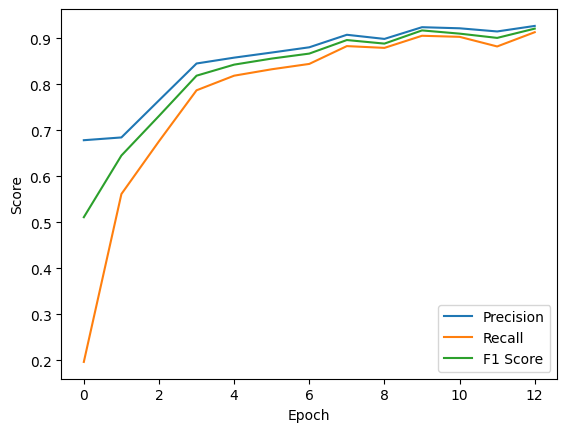

In [22]:
# Sonuçları görselleştirelim
import matplotlib.pyplot as plt

plt.plot(history.history['precision'], label='Precision')
plt.plot(history.history['recall'], label='Recall')
plt.plot(history.history['f1_score'], label='F1 Score')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.legend()
plt.show()


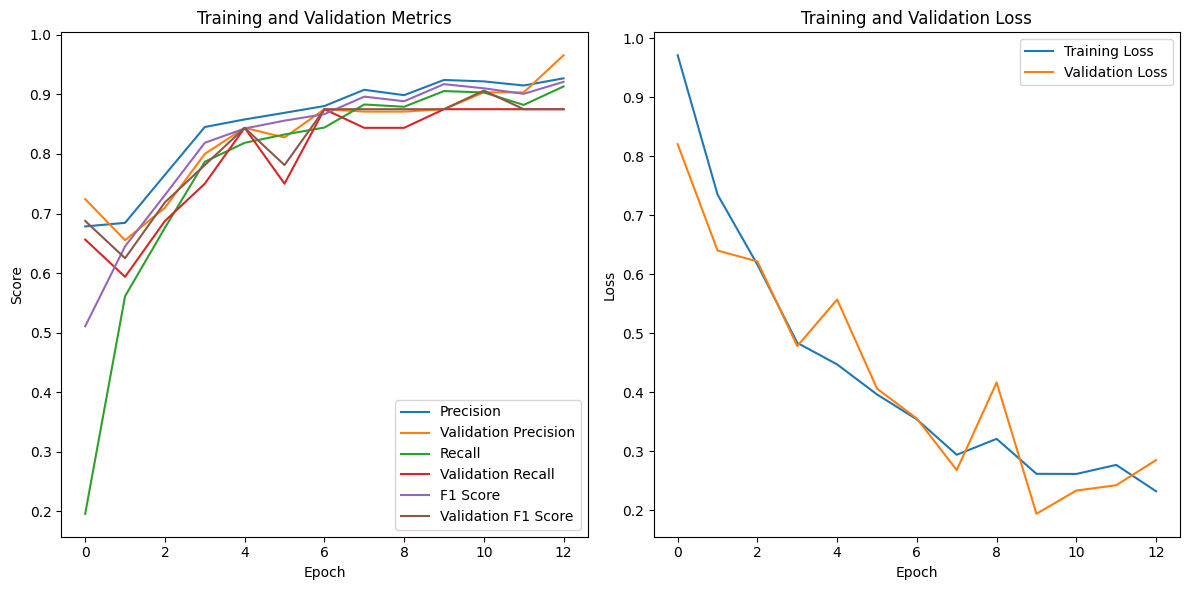

In [25]:
import matplotlib.pyplot as plt

# Metriklerin Görselleştirilmesi
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)  # 1 satır, 2 sütun, 1. grafik
plt.plot(history.history['precision'], label='Precision')
plt.plot(history.history['val_precision'], label='Validation Precision')
plt.plot(history.history['recall'], label='Recall')
plt.plot(history.history['val_recall'], label='Validation Recall')
plt.plot(history.history['f1_score'], label='F1 Score')
plt.plot(history.history['val_f1_score'], label='Validation F1 Score')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.legend()
plt.title('Training and Validation Metrics')

# Kayıpların Görselleştirilmesi
plt.subplot(1, 2, 2)  # 1 satır, 2 sütun, 2. grafik
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.tight_layout()
plt.show()


In [26]:
# Test veri setini yükleyin ve ön işleme yapın (ör. boyutunu yeniden şekillendirme, normalleştirme vb.)
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    '/content/data/Test/Test',
    target_size=(225, 225),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Verilerin karıştırılmaması için shuffle=False yapın
)

# Modeli test veri seti üzerinde değerlendirin
test_loss, test_accuracy, test_precision, test_recall, test_f1_score = model.evaluate(test_generator)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)
print("Test Precision:", test_precision)
print("Test Recall:", test_recall)
print("Test F1 Score:", test_f1_score)


Found 150 images belonging to 3 classes.
5/5 [==============================] - 9s 2s/step - loss: 0.2742 - accuracy: 0.9333 - precision: 0.9333 - recall: 0.9333 - f1_score: 0.9333
Test Loss: 0.27415257692337036
Test Accuracy: 0.9333333373069763
Test Precision: 0.9333333373069763
Test Recall: 0.9333333373069763
Test F1 Score: 0.9333333373069763


CONFUSION MATRİX

5/5 [==============================] - 9s 2s/step


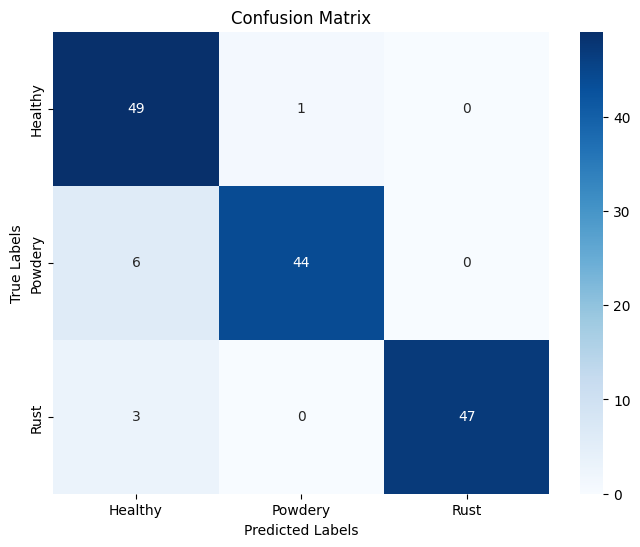

In [27]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Test veri setinden tahminleri ve gerçek etiketleri alın
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes

# Konfüzyon matrisini oluşturun
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Sınıf etiketlerini alın
class_labels = list(test_generator.class_indices.keys())

# Konfüzyon matrisini görselleştirin
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


TEST SONUÇLARINI GÖRSEL ÜZERİNDEN DEĞERLENDİRELİM

In [31]:
total_samples = len(test_generator) * test_generator.batch_size
print(total_samples)

160


9/9 [==============================] - 0s 22ms/step


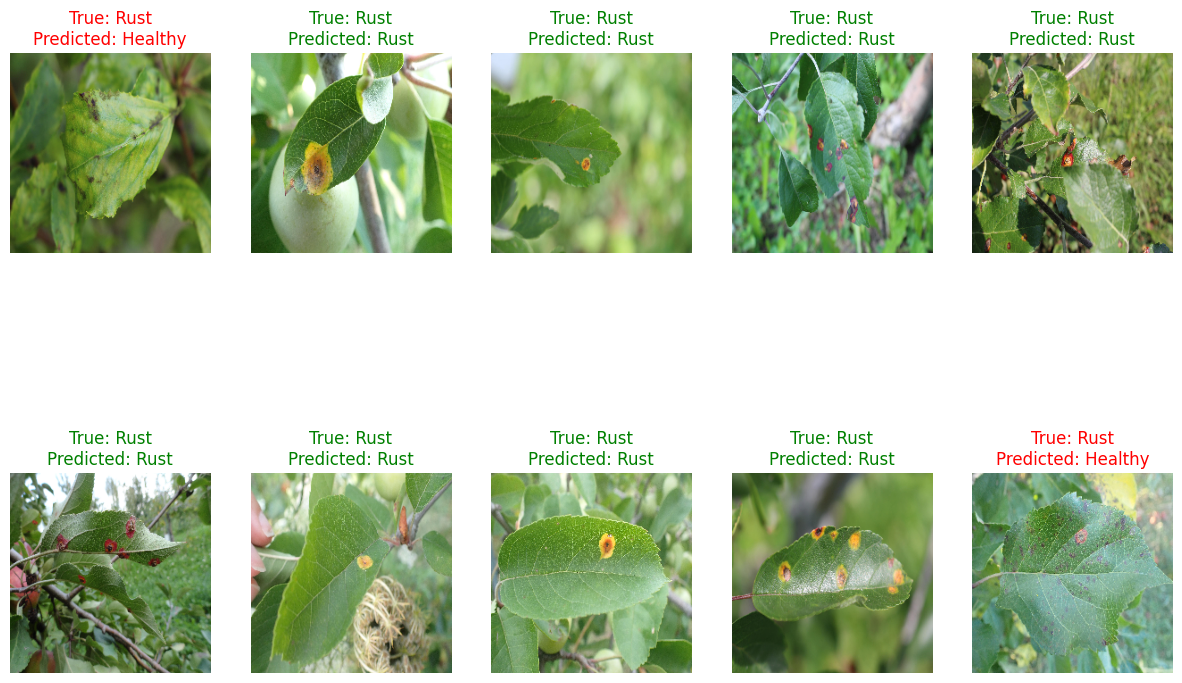

In [33]:
import random

# Test veri setindeki toplam örnek sayısını alın
total_samples = len(test_generator) * test_generator.batch_size

# Rastgele 10 resim seçin
random_indices = random.sample(range(total_samples), min(10, total_samples))
sample_images = []
sample_labels = []

for idx in random_indices:
    batch_images, batch_labels = test_generator[idx % len(test_generator)]  # Mod işlemi, indeksi döngüye alır
    sample_images.extend(batch_images)
    sample_labels.extend(batch_labels)

sample_images = np.array(sample_images)
sample_labels = np.array(sample_labels)

# Model tarafından yapılan tahminleri alın
predictions = model.predict(sample_images)
predicted_classes = np.argmax(predictions, axis=1)

# Resimlerin ve tahminlerin görselleştirilmesi
plt.figure(figsize=(15, 10))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(sample_images[i])
    true_label = class_labels[np.argmax(sample_labels[i])]
    predicted_label = class_labels[predicted_classes[i]]
    if true_label == predicted_label:
        color = 'green'
    else:
        color = 'red'
    plt.title(f'True: {true_label}\nPredicted: {predicted_label}', color=color)
    plt.axis('off')
plt.show()


1/1 [==============================] - 0s 30ms/step


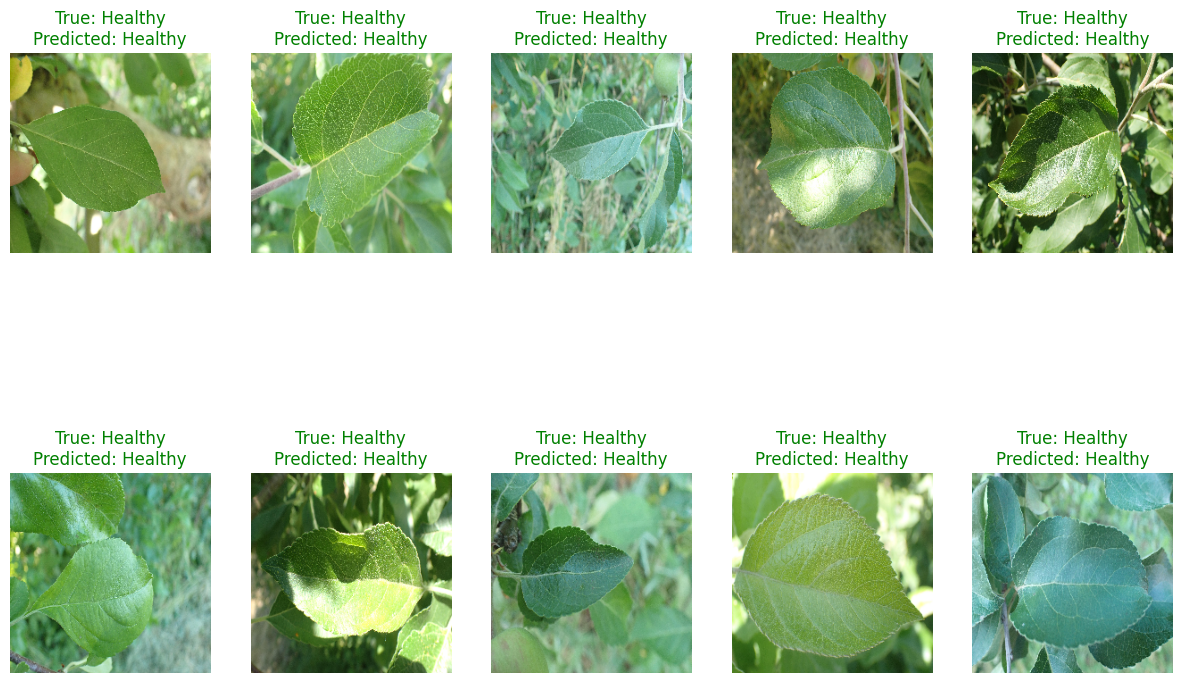

In [35]:
import matplotlib.pyplot as plt

# Test veri setinden bir örnek resim seçin
sample_images, sample_labels = next(test_generator)

# Model tarafından yapılan tahminleri alın
predictions = model.predict(sample_images)
predicted_classes = np.argmax(predictions, axis=1)

# Resimlerin ve tahminlerin görselleştirilmesi
plt.figure(figsize=(15, 10))
for i in range(10):  # İlk 10 resmi görselleştirin
    plt.subplot(2, 5, i+1)
    plt.imshow(sample_images[i])
    true_label = class_labels[np.argmax(sample_labels[i])]
    predicted_label = class_labels[predicted_classes[i]]
    if true_label == predicted_label:
        color = 'green'
    else:
        color = 'red'
    plt.title(f'True: {true_label}\nPredicted: {predicted_label}', color=color)
    plt.axis('off')
plt.show()


MODELİ DRIVE a KAYDEDELİM

In [37]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [38]:
# Modeli kaydet
model.save("/content/drive/MyDrive/DerinOgrenme/plant_disease_model.h5")


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
